In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


In [8]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
             

/kaggle/input/sensor-data-project/labapp3-data-new.txt


In [9]:
column_names = ["time", "nodeid", "temperature", "humidity", "light", "voltage"]
df = pd.read_csv("/kaggle/input/sensor-data-project/labapp3-data-new.txt", sep=" ", names=column_names, header=None)

np.random.seed(42)
df = df[df['nodeid'] <= 60]
df = df.sample(frac = 0.8)
df['time'] = pd.to_datetime(df['time'], unit='s')

In [10]:
df.isnull().sum()

time               0
nodeid             0
temperature      304
humidity         302
light          74381
voltage            0
dtype: int64

In [11]:
# Preprocessing: Fill missing values
df['temperature'] = df['temperature'].interpolate(method='linear')
df['humidity'] = df['humidity'].interpolate(method='linear')
df['light'] = df['light'].interpolate(method='linear')
df = df.drop_duplicates()

In [12]:
df.isnull().sum()

time           0
nodeid         0
temperature    0
humidity       0
light          0
voltage        0
dtype: int64

In [13]:
df.isna().sum()

time           0
nodeid         0
temperature    0
humidity       0
light          0
voltage        0
dtype: int64

In [17]:
df.isin([np.inf, -np.inf]).sum()

time           0
nodeid         0
temperature    0
humidity       0
light          0
voltage        0
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

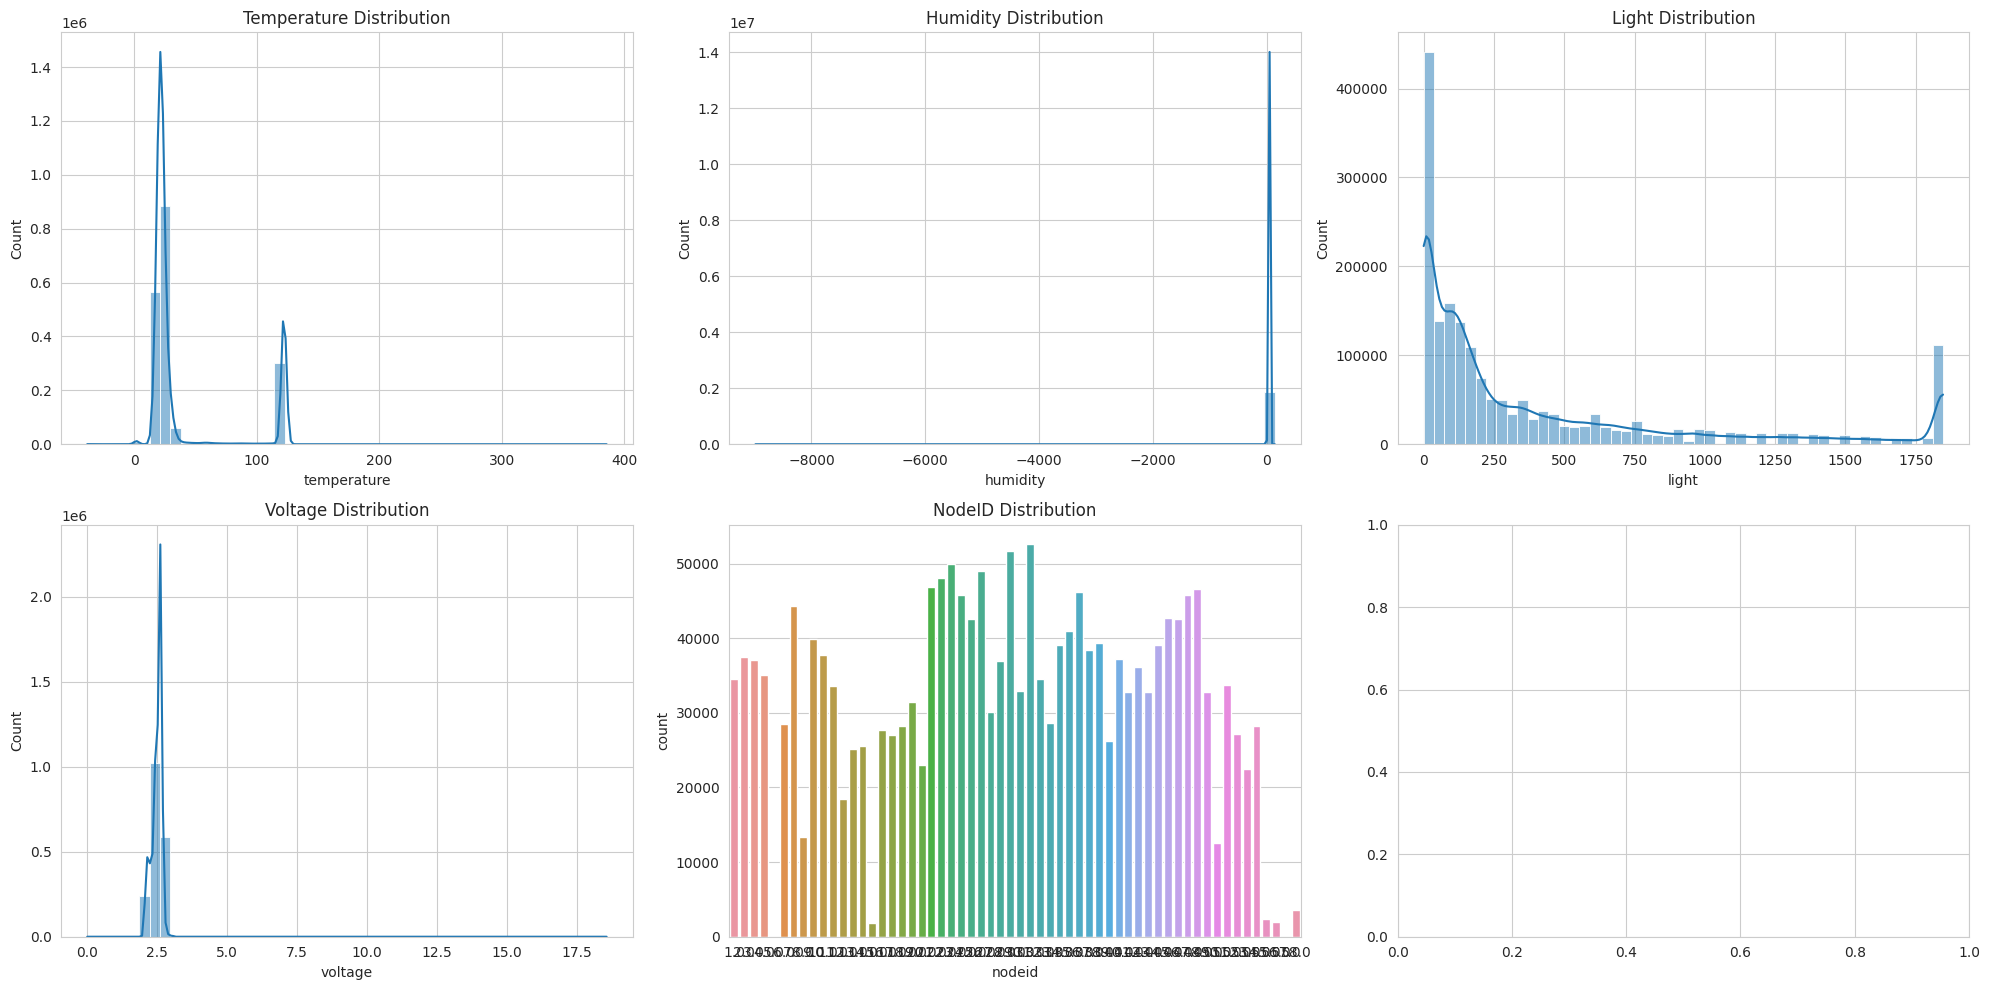

In [14]:
#data Visualization
sns.set_style("whitegrid")

# Plot data distribution for each feature
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

sns.histplot(df['temperature'], ax=axes[0, 0], bins=50, kde=True).set_title('Temperature Distribution')
sns.histplot(df['humidity'], ax=axes[0, 1], bins=50, kde=True).set_title('Humidity Distribution')
sns.histplot(df['light'], ax=axes[0, 2], bins=50, kde=True).set_title('Light Distribution')
sns.histplot(df['voltage'], ax=axes[1, 0], bins=50, kde=True).set_title('Voltage Distribution')
sns.countplot(data=df, x='nodeid', ax=axes[1, 1]).set_title('NodeID Distribution')

plt.tight_layout()
plt.show()

In [18]:
#Outliers
def handle_outliers(column):
    """Handles outliers in the column using the IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with NaN for later interpolation
    outliers_count = df[column].apply(lambda x: 1 if x is not None and (x < lower_bound or x > upper_bound) else 0).sum()
    df[column] = df[column].apply(lambda x: x if lower_bound <= x <= upper_bound else None)
    
    return outliers_count

# Dictionary to store the count of outliers for each column
outliers_counts = {}

# Handle outliers for relevant columns and store the count
for col in ['temperature', 'humidity', 'light', 'voltage']:
    outliers_counts[col] = handle_outliers(col)

# Check the new number of null values after handling outliers
new_null_counts = df.isnull().sum()

# Print the count of outliers for each column
for col, count in outliers_counts.items():
    print(f'Number of outliers in {col}: {count}')
result_df=df    

Number of outliers in temperature: 342969
Number of outliers in humidity: 250946
Number of outliers in light: 183508
Number of outliers in voltage: 5766


In [ ]:
#LSTM
# Making features dataframe by removing the label column
# features_df = cleanInput.drop("Temprature", axis=1)
# features_df = features_df.drop("Node_ID", axis=1)

In [19]:
features_df = result_df.drop("nodeid", axis=1)
features_df = features_df.drop("time", axis=1)
features_df = features_df.drop("voltage", axis=1)
features_df = features_df.drop("light", axis=1)
features_df = features_df.drop("humidity", axis=1)

# Here define the sequence size - CHANGE IT WHEN FINE TUNNING
window_size = 48
predict_window_size = 12

# Transform dataframe to numpy
numpy_features_df = features_df.to_numpy()
numpy_df = result_df.to_numpy()

# Define X as array of features
# Define Y as array of actual output (label)
X=[]
Y=[]
Y_plot=[]
for i in range(len(numpy_df) - (window_size + predict_window_size)):
  # Use all features except for Tempreture -------------------------------------
  row = [r for r in numpy_features_df[i:i+window_size]]
  label=[]
  # Use this line if you want to predict one value
  label_plot = numpy_df[i+window_size][2]
  # Use this line only if you want to predict a sequece of values
  # label = [r1 for r1 in numpy_df[(i+window_size):(i+window_size+predict_window_size)][r1][2]]
  for x in range(predict_window_size):
    for r1 in [numpy_df[(i+window_size):(i+window_size+predict_window_size)][x]]:
      label.append(r1[2])
  X.append(row)
  Y.append(label)
  Y_plot.append(label_plot)



# converting into numpy
X1 = np.array(X)
Y1 = np.array(np.array(Y))

In [20]:
# Checking for shape (#examples, window_size, features)
X1.shape, Y1.shape

((1850236, 48, 1), (1850236, 12))

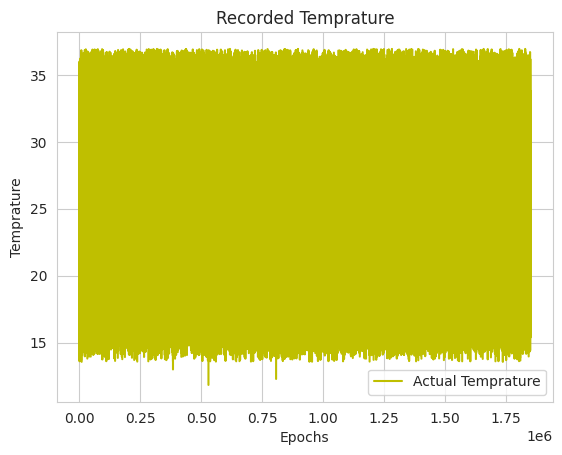

In [21]:
# Plotting Prediction vs. actual values for training dataset
epochs = range(1, len(Y1)+1)
plt.plot(epochs, Y_plot, "y",label="Actual Temprature")
# plt.plot(epochs, train_predictions, "r", label="Predicted Temp")
plt.title("Recorded Temprature")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Temprature")
plt.show()

In [22]:
import math

# Should ramdomize X1 and Y1 before splitting-----------------------------------

# print(len(Y1))
split1 = math.floor(len(Y1) * 0.1)
# print(split1)
split2 = math.floor(len(Y1) * 0.2)
# print(split2)

X_test = X1[:split1]
X_val = X1[split1:split2]
X_train = X1[split2:]

Y_test = Y1[:split1]
Y_val = Y1[split1:split2]
Y_train = Y1[split2:]

Y_plot_test = Y_plot[:split1]
Y_plot_val = Y_plot[split1:split2]
Y_plot_train = Y_plot[split2:]

# X_train.shape, Y_train.shape
# X_val.shape, Y_val.shape
# X_test.shape, Y_test.shape

In [23]:
model = Sequential()
model.add(InputLayer((window_size, 1)))
# model.add(Dropout(0.25))
model.add(LSTM(128))
# model.add(Dropout(0.2))
model.add(Dense(8, "relu"))
# model.add(Dropout(0.1))
model.add(Dense(1, "linear"))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,601 (264.07 KB)

 Trainable params: 67,601 (264.07 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
checkPoint = ModelCheckpoint("model/model_checkpoint.keras", save_best_only = True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [29]:
hostory = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), verbose=1, epochs=100, callbacks=[checkPoint])

Epoch 1/100
16236/46256 ━━━━━━━━━━━━━━━━━━━━ 21:53 44ms/step - loss: nan - root_mean_squared_error: nan

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46256/46256 ━━━━━━━━━━━━━━━━━━━━ 2149s 46ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 2/100
13058/46256 ━━━━━━━━━━━━━━━━━━━━ 24:35 44ms/step - loss: nan - root_mean_squared_error: nan

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29396/46256 ━━━━━━━━━━━━━━━━━━━━ 12:38 45ms/step - loss: nan - root_mean_squared_error: nan

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43082/46256 ━━━━━━━━━━━━━━━━━━━━ 2:22 45ms/step - loss: nan - root_mean_squared_error: nan

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46256/46256 ━━━━━━━━━━━━━━━━━━━━ 2179s 47ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 3/100
46256/46256 ━━━━━━━━━━━━━━━━━━━━ 2163s 47ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/100
 2413/46256 ━━━━━━━━━━━━━━━━━━━━ 32:38 45ms/step - loss: nan - root_mean_squared_error: nan

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("model/")

In [ ]:
# Testing LSTM model

train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

In [ ]:
# Plotting Learning curve
# Typo hostory :)

training_loss = hostory.history["loss"]
val_loss = hostory.history["val_loss"]
epochs = range(1, len(training_loss)+1)

plt.plot(epochs, training_loss, "y", label="Training Loss")
# plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Learning Curves")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Plotting Prediction vs. actual values for training dataset
epochs = range(1, len(Y_plot_train)+1)
plt.plot(epochs, Y_plot_train, "y", label="Actual Temperature")
plt.plot(epochs, train_predictions, "r", label="Predicted Temp")
plt.title("Comparison Curves")
plt.legend()
plt.xlabel("Records")
plt.ylabel("Temperature")
plt.show()

In [ ]:
# Plotting Prediction vs. actual values for test dataset
epochs = range(1, len(Y_plot_test)+1)
plt.plot(epochs, Y_plot_test, "y", label="Actual Temprature")
plt.plot(epochs, test_predictions, "r", label="Predicted Temp")
plt.title("Comparison Curves")
plt.legend()
plt.xlabel("Records")
plt.ylabel("Temperature")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(Y_plot_test, test_predictions)
mae = mean_absolute_error(Y_plot_test, test_predictions)
mse,mae